In [1]:
import torch
from torch import nn
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F

from asdfghjkl import batch_gradient
from laplace.curvature.asdl import _get_batch_grad

import sys

sys.path.append("../stochman")

from stochman import nnj

sys.path.append("../../Laplace")
from laplace.laplace import Laplace
from torch.utils.data import DataLoader, TensorDataset


In [2]:
def get_model(number_of_layers, device, data_resolution, conv=False):

    if not conv:
        model = [nn.Linear(data_resolution, data_resolution)]
        for i in range(number_of_layers-1):
            model += [nn.Tanh(), nn.Linear(data_resolution, data_resolution)]
        model = nn.Sequential(*model).to(device)

    else:
        model = [nn.Conv2d(data_resolution, data_resolution, kernel_size=(3,3), padding=(1,1), stride=1, bias=False)]
        for i in range(number_of_layers-1):
            model += [nn.Tanh(), nn.Conv2d(data_resolution, data_resolution, kernel_size=(3,3), padding=(1,1), stride=1, bias=False)]
        model = nn.Sequential(*model).to(device)    

    return model

def get_model_stochman(number_of_layers, device, data_resolution, conv=False):

    if not conv:
        model = [nnj.Linear(data_resolution, data_resolution)]
        for i in range(number_of_layers-1):
            model += [nnj.Tanh(), nnj.Linear(data_resolution, data_resolution)]
        model = nn.Sequential(*model).to(device)
    
    else:
        model = [nnj.Conv2d(data_resolution, data_resolution, kernel_size=(3,3), padding=(1,1), stride=1, bias=False)]
        for i in range(number_of_layers-1):
            model += [nnj.Tanh(), nnj.Conv2d(data_resolution, data_resolution, kernel_size=(3,3), padding=(1,1), stride=1, bias=False)]
        model = nn.Sequential(*model).to(device)    
        
    return model

In [3]:
def jacobians(x, model, output_size=784):
    jacobians = list()
    f = None
    for i in range(output_size):
        def loss_fn(outputs, targets):
            return outputs[:, i].sum()

        f = batch_gradient(model, loss_fn, x, None).detach()
        jacobian_i = _get_batch_grad(model)

        jacobians.append(jacobian_i)
    jacobians = torch.stack(jacobians, dim=1)
    return jacobians, f

def jacobians_conv(x, model, output_size=784):
    jacobians = list()
    f = None
    for c in range(output_size):
        for h in range(output_size):
            for w in range(output_size):
                def loss_fn(outputs, targets):
                    return outputs[:, c, h, w].sum()

                f = batch_gradient(model, loss_fn, x, None).detach()
                jacobian_i = _get_batch_grad(model)

                jacobians.append(jacobian_i)
    jacobians = torch.stack(jacobians, dim=1)
    return jacobians, f
    
def run_row(x, data_resolution, model, conv=False):

    t0 = time.perf_counter()
    if not conv:
        Js_row, _ = jacobians(x, model, output_size=data_resolution)      
    else:
        Js_row, _ = jacobians_conv(x, model, output_size=data_resolution)        
    Hs_row = torch.einsum("nji,njk->nik", Js_row, Js_row)
    elapsed_row = time.perf_counter() - t0
    #print(Js_row.shape, Hs_row.shape)

    return Hs_row.detach().cpu(), elapsed_row


In [4]:
def run_laplace(x, data_resolution, model, conv=False, number_of_layers=0, device=None):

    nn_model = get_model(number_of_layers, device, data_resolution, conv=conv)
    for nn_layer, nnj_layer in zip(nn_model, model):
        if hasattr(nn_layer,'weight'):
            nn_layer.weight = nnj_layer.weight
        if hasattr(nn_layer,'bias'):
            nn_layer.bias = nnj_layer.bias

    t0 = time.perf_counter()
    dataset = TensorDataset(x, x)
    dataloader = DataLoader(dataset, batch_size=32)
    la = Laplace(
        nn_model,
        "regression",
        hessian_structure="diag",
        subset_of_weights="all",
    )
    la.fit(dataloader)
    elapsed_la = time.perf_counter() - t0

    return la.H.detach().cpu(), elapsed_la

In [5]:
def run_layer(x, data_resolution, model, conv=False):
    t0 = time.perf_counter()

    bs = x.shape[0]
    H = []

    feature_maps = []

    def fw_hook_get_latent(module, input, output):
        feature_maps.append(output.detach())

    for k in range(len(model)):
        model[k].register_forward_hook(fw_hook_get_latent)

    model(x)
    feature_maps = [x] + feature_maps
    if conv:
        tmp = torch.diag_embed(torch.ones(data_resolution**3, device=x.device)).expand(bs,-1,-1)
    else:
        tmp = torch.diag_embed(torch.ones(data_resolution, device=x.device)).expand(bs,-1,-1)

    with torch.no_grad():
        for k in range(len(model) - 1, -1, -1):

            # jacobian w.r.t weight
            h_k = model[k]._jacobian_wrt_weight_sandwich(
                feature_maps[k],
                feature_maps[k + 1],
                tmp,
                diag=False,
            )
            if h_k is not None:
                H = [h_k.sum(dim=0)] + H
                #print(f"hessian for layer {k} has shape {h_k.shape}")
            
            # jacobian w.r.t input
            tmp = model[k]._jacobian_wrt_input_sandwich(
                feature_maps[k],
                feature_maps[k + 1],
                tmp,
                diag=False,
            )
    H = torch.cat(H, dim=0)
    elapsed_layer = time.perf_counter() - t0

    return H.detach().cpu(), elapsed_layer

# Compute and check results

In [6]:
def compute_hessians(number_of_layers=5, batch_size=10, data_resolution=5, convolutions=True, do_laplace=False):

    if convolutions:
        data = torch.randint(1,10,(batch_size,data_resolution,data_resolution,data_resolution)).float()
    else:
        data = torch.randint(1,10,(batch_size,data_resolution)).float()

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model = get_model_stochman(number_of_layers, device, data_resolution, conv=convolutions)


    Hs_row, t_row = run_row(data, data_resolution, model, conv=convolutions)
    Hs_row = Hs_row.sum(dim=0) #sum over batch size

    Hs_layer, t_layer = run_layer(data, data_resolution, model, conv=convolutions)
    
    if do_laplace:
        Hs_laplace, t_laplace = run_laplace(data, data_resolution, model, conv=convolutions,
                                            number_of_layers=number_of_layers, device=device)
    else:
        Hs_laplace, t_laplace = None, None

    return Hs_row, t_row, Hs_laplace, t_laplace, Hs_layer, t_layer

In [7]:
def check_correctness(number_of_layers=5, batch_size=10, data_resolution=5, convolutions=True, do_laplace=False, plot=True):
    Hs_row, t_row, Hs_laplace, t_laplace, Hs_layer, t_layer = compute_hessians(number_of_layers = number_of_layers, 
                                                                        batch_size = batch_size, 
                                                                        data_resolution = data_resolution, 
                                                                        convolutions = convolutions,
                                                                        do_laplace = do_laplace)
    if do_laplace:
        print(Hs_row.shape, Hs_laplace.shape, Hs_layer.shape)
        print(f"Times \n -row method: {t_row}\n -laplace method: {t_laplace}\n -layer method: {t_layer}")
    else:
        print(Hs_row.shape, Hs_layer.shape)
        print(f"Times \n -row method: {t_row}\n -layer method: {t_layer}")
    
    if convolutions:
        if number_of_layers==1:
            print('Error max abs value:', torch.max(torch.abs(Hs_row - Hs_layer)) )
        else:
            layer_times_w, w = Hs_layer.shape
            assert layer_times_w == number_of_layers*w
            for l in range(number_of_layers):
                block_Hs_row = Hs_row[w*l:w*(l+1), w*l:w*(l+1)] 
                block_Hs_layer = Hs_layer[w*l:w*(l+1), :] 
                print('Error max abs value on layer',l,':', torch.max(torch.abs(block_Hs_row - block_Hs_layer)) )
        
        if plot:
            plt.figure()
            plt.imshow(Hs_row.numpy())
            plt.figure()
            plt.imshow(Hs_layer.numpy())

    else:
        print('Error max abs value (ours):', torch.max(torch.abs( Hs_layer - torch.diagonal(Hs_row) )) )
        print('Error max abs value (laplace):', torch.max(torch.abs( Hs_laplace - Hs_row )) )


In [8]:
check_correctness(number_of_layers = 5, 
                  batch_size = 10, 
                  data_resolution = 30, 
                  convolutions = False, 
                  do_laplace = True, 
                  plot = True)

torch.Size([4650, 4650]) torch.Size([4650]) torch.Size([4650])
Times 
 -row method: 0.265658185002394
 -laplace method: 0.005514163000043482
 -layer method: 0.0021826330048497766
Error max abs value (ours): tensor(7.1526e-07)
Error max abs value (laplace): tensor(12.6412)


torch.Size([1125, 1125]) torch.Size([1125, 225])
Times 
 -row method: 0.4046459569945
 -layer method: 0.11467833400820382
Error max abs value on layer 0 : tensor(1.9073e-06)
Error max abs value on layer 1 : tensor(9.5367e-07)
Error max abs value on layer 2 : tensor(7.1526e-07)
Error max abs value on layer 3 : tensor(4.7684e-07)
Error max abs value on layer 4 : tensor(4.7684e-07)


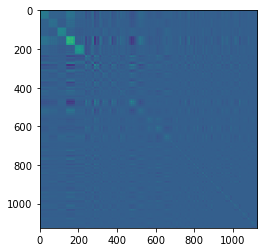

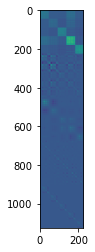

In [9]:
check_correctness(number_of_layers = 5, 
                  batch_size = 10, 
                  data_resolution = 5, 
                  convolutions = True, 
                  do_laplace = False, 
                  plot = True)

number_of_layers 0
number_of_layers 10
number_of_layers 20
number_of_layers 30
number_of_layers 40
number_of_layers 50
number_of_layers 60
number_of_layers 70
number_of_layers 80
number_of_layers 90
data_resolution 10
data_resolution 20
data_resolution 30
data_resolution 40
data_resolution 50
data_resolution 60
data_resolution 70
data_resolution 80
data_resolution 90


Text(0.5, 1.0, 'Time for data resolution (linear)')

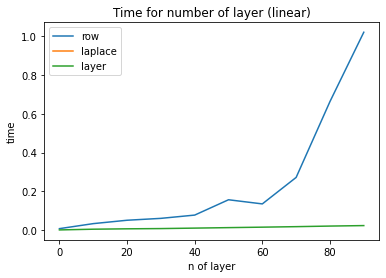

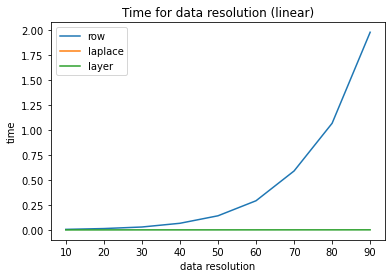

In [10]:
convolutions = False
number_of_layersS = range(0,100,10)
data_resolutions = range(10,100,10)


ts_row, ts_laplace, ts_layer = [], [], []
for number_of_layers in number_of_layersS:
    print('number_of_layers',number_of_layers)
    _, t_row, _, t_laplace, _, t_layer = compute_hessians(number_of_layers = number_of_layers, 
                                                        batch_size = 2, 
                                                        data_resolution = 10, 
                                                        convolutions = convolutions)
    ts_row.append(t_row)
    ts_laplace.append(t_laplace)
    ts_layer.append(t_layer)
plt.figure()
plt.plot(number_of_layersS, ts_row, label='row')
plt.plot(number_of_layersS, ts_laplace, label='laplace')
plt.plot(number_of_layersS, ts_layer, label='layer')
plt.xlabel('n of layer')
plt.ylabel('time')
plt.legend()
plt.title('Time for number of layer (linear)')


ts_row, ts_laplace, ts_layer = [], [], []
for data_resolution in data_resolutions:
    print('data_resolution',data_resolution)
    _, t_row, _, t_laplace, _, t_layer = compute_hessians(number_of_layers = 3, 
                                                        batch_size = 2, 
                                                        data_resolution = data_resolution, 
                                                        convolutions = convolutions)
    ts_row.append(t_row)
    ts_laplace.append(t_laplace)
    ts_layer.append(t_layer)
plt.figure()
plt.plot(data_resolutions, ts_row, label='row')
plt.plot(data_resolutions, ts_laplace, label='laplace')
plt.plot(data_resolutions, ts_layer, label='layer')
plt.xlabel('data resolution')
plt.ylabel('time')
plt.legend()
plt.title('Time for data resolution (linear)')

number_of_layers 0
number_of_layers 10
number_of_layers 20
number_of_layers 30
number_of_layers 40
number_of_layers 50
number_of_layers 60
number_of_layers 70
data_resolution 3
data_resolution 4
data_resolution 5
data_resolution 6
data_resolution 7
data_resolution 8
data_resolution 9


Text(0.5, 1.0, 'Time for data resolution (convolutions)')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

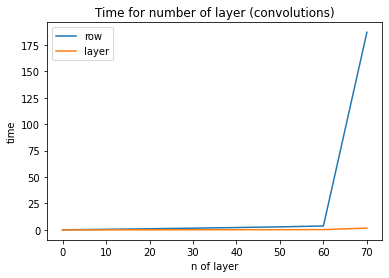

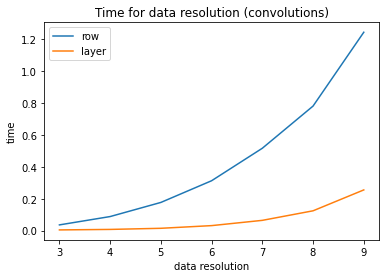

In [11]:
convolutions = True
number_of_layersS = range(0,80,10)
data_resolutions = range(3,10,1)


ts_row, ts_layer = [], []
for number_of_layers in number_of_layersS:
    print('number_of_layers',number_of_layers)
    _, t_row, _, _, _, t_layer = compute_hessians(number_of_layers = number_of_layers, 
                                                        batch_size = 2, 
                                                        data_resolution = 5, 
                                                        convolutions = convolutions)
    ts_row.append(t_row)
    ts_layer.append(t_layer)
    plt.figure()
plt.plot(number_of_layersS, ts_row, label='row')
plt.plot(number_of_layersS, ts_layer, label='layer')
plt.xlabel('n of layer')
plt.ylabel('time')
plt.legend()
plt.title('Time for number of layer (convolutions)')



ts_row, ts_layer = [], []
for data_resolution in data_resolutions:
    print('data_resolution',data_resolution)
    _, t_row, _, _, _, t_layer = compute_hessians(number_of_layers = 3, 
                                                        batch_size = 2, 
                                                        data_resolution = data_resolution, 
                                                        convolutions = convolutions)
    ts_row.append(t_row)
    ts_layer.append(t_layer)
plt.figure()
plt.plot(data_resolutions, ts_row, label='row')
plt.plot(data_resolutions, ts_layer, label='layer')
plt.xlabel('data resolution')
plt.ylabel('time')
plt.legend()
plt.title('Time for data resolution (convolutions)')

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = get_model_stochman(5, device, 4, conv=convolutions)

for layer in model:
    if hasattr(layer,'weight'):
        print(layer.bias)

None
None
None
None
None
